# <b> <center style="background-color:DodgerBlue;"> Image Captioning  </center> </b>

In [ ]:
# -*- coding: utf-8 -*-
# Indentation: Jupyter Notebook

'''
image captioning

'''

__version__ = 1.0
__author__ = "Sourav Raj"
__author_email__ = "sourav.raj@ril.com"

In [113]:
import imp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.image as img

#Import Necessary Libraries
from os import listdir
from pickle import dump, load
import pickle 

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L1L2

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, concatenate
from tensorflow.keras.optimizers import Adam, SGD

from src.image_prepocessor import read_image_caption
from src.image_feature_extraction import image_feature_extraction

In [ ]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of 
                        # numbers will appear every time. 
#tf.set_random_seed(42)  # sets the graph-level random seed
tf.random.set_seed(42)

In [145]:
image_directory='../../../data/explore/image_caption_generator/Image_captioning_Dataset/Flicker8k_Dataset/'
img_caption_pkl=pd.read_pickle('../../../data/explore/image_caption_generator/set_0.pkl')

### Reading Image Captions 

In [146]:

image_captions=read_image_caption(img_caption_pkl)
print(image_captions.shape)
image_captions.head(2)

2837799692_2f1c50722a.jpg#4	Closeup of football player # 25 . 2
3273625566_2454f1556b.jpg#4	A race dog have a muzzle and be wear striped jersey # 8 . 2
2837799692_2f1c50722a.jpg#3	a university of Miami football player # 25 . 2
3147913471_322ea231d9.jpg#2	Florida man 's basketball player # 33 shoot basketball . 2
2833582518_074bef3ed6.jpg#4	A # 2 greyhound dog be run around a track . 2
2769605231_dae8b30201.jpg#1	A black greyhound , with a green and white jersey ( # 7 ) be run on a track . 2
(25000, 3)


,image,captionId,caption
0,318667317_108c402140,4,A man in a black hoodie be hold a paper sign .
1,2072574835_febf0c5fb9,4,Three race dog be run out of the start gate on...


In [147]:
image_captions[image_captions['image']=='319847657_2c40e14113'].head()

,image,captionId,caption
9948,319847657_2c40e14113,3,A woman be tug on a white sheet and laugh
16427,319847657_2c40e14113,1,A girl in a purple shirt be have pull someone ...


Observation: some image have more than 1 captions.

In [148]:
image_captions.drop_duplicates().shape

(25000, 3)

In [149]:
image_captions.captionId.nunique(), image_captions.image.nunique(), image_captions.caption.nunique()

(5, 8037, 24817)

### Ploting few images with its caption

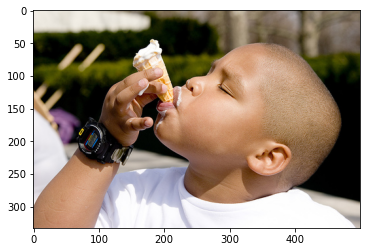

Given Sequence are for this image are: 

A young boy wear a big watch eat an ice cream cone .
A young boy eat ice cream .
Little boy be eat the rest of an ice cream cone from the bottom up .
A boy with his eye close eat the bottom of an ice cream cone .
A boy be put the cone end of a melt ice cream cone in his mouth .


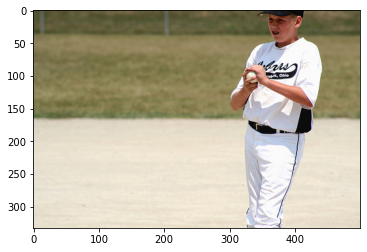

Given Sequence are for this image are: 

A boy be wear a white baseball uniform and hold a baseball .
a boy in white play baseball .
Little leaguer get ready for pitch
A young Ohio baseball player contemplate his pitch .
A young boy be get ready to through a baseball


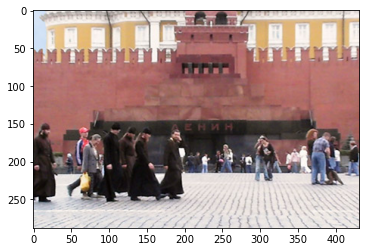

Given Sequence are for this image are: 

A city square with a large red wall and person walk about .


In [152]:
# image_directory='Image_captioning_Dataset/Flicker8k_Dataset'
for image in random.sample(list(image_captions.image), 3):
    plt.figure()
    im = img.imread(image_directory + '/'+ image + '.jpg')
    plt.imshow(im) 
    plt.show()
    print(f'Given Sequence are for this image are: \n')
        
    for caption in image_captions[image_captions['image']==image].caption.values:#.iloc[0]
        print(caption)
#     print(image_captions[image_captions['image']==image].caption.iloc[0])
    


### Image Feature extraction 

In [16]:
resnet50=ResNet50()
# resnet50=load_model('../../../data/explore/image_caption_generator/resnet50.h5')
image_features = image_feature_extraction(image_directory, resnet50)
print('Extracted Features: %d' % len(image_features))
# save to file
dump(image_features, open('../../../data/explore/image_caption_generator/output/image_features_reset50.pkl', 'wb'))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________


Extracted Features: 8091


In [31]:
# load features from pickle
with open(os.path.join('../../../data/explore/image_caption_generator/output/image_features_reset50.pkl'), 'rb') as f:
    image_features = load(f)

In [32]:
len(image_features), image_captions.image.nunique()

(8091, 8037)

There are mismatch in the image available in image directory in comparision to captions. Let's remove image name from image_captions which are not available

In [74]:
image_captions=image_captions[image_captions['image'].isin(image_features.keys())]
print(len(image_features), image_captions.image.nunique(), image_captions.shape)

8091 8036 (24996, 3)


### Caption Preprocessing

Removing numbers, special character, addition spaces & changing all the word to lower case

Start and End Sequence has to be added to the tokens so that it's easier to identify the captions for the image as each of them are of different length

In [75]:
def caption_preprocessing(caption):
    # preprocessing steps
    # convert to lowercase, delete digits, special chars & additional spaces
    caption = caption.lower().replace('[^A-Za-z]', '').replace('\s+', ' ')
    # add start and end tags to the caption
    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
    return caption
image_captions['caption']=image_captions['caption'].apply(caption_preprocessing)
image_captions['image_feature']=image_captions['image'].apply(lambda x: image_features[x][0])
image_captions.head()

,image,captionId,caption,image_feature
0,318667317_108c402140,4,startseq man in black hoodie be hold paper sig...,"[0.34249333, 0.36296466, 0.002094434, 0.805999..."
1,2072574835_febf0c5fb9,4,startseq three race dog be run out of the star...,"[0.34385532, 0.19550037, 0.6508237, 2.041569, ..."
2,3083016677_5782bc337c,4,startseq two motorcycle with two rider each en...,"[1.0154637, 4.204777, 0.43433255, 0.04175122, ..."
3,95734038_2ab5783da7,0,startseq man on bike nest to river endseq,"[0.67103887, 0.19373809, 0.27402854, 0.0329701..."
4,241346146_f27759296d,1,startseq football player try tackle another pl...,"[0.11336415, 2.6156332, 0.0, 1.4476278, 0.0714..."


### Tokenising the caption to convert text to numerical

In [76]:
image_captions_all=image_captions['caption'].values
print(len(image_captions_all))
image_captions_all[0:5]

24996


array(['startseq man in black hoodie be hold paper sign endseq',
       'startseq three race dog be run out of the start gate on track endseq',
       'startseq two motorcycle with two rider each endseq',
       'startseq man on bike nest to river endseq',
       'startseq football player try tackle another player who have the ball endseq'],
      dtype=object)

In [77]:
# tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(image_captions_all)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

5340


In [78]:
# get maximum length of the caption available
max_len_caption = max([len(caption.split()) for caption in image_captions_all])
max_len_caption

31

In [81]:
image_captions['caption_token']=image_captions['caption'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])

In [82]:
image_captions.image.nunique()

8036

In [83]:
image_captions.head(2)

,image,captionId,caption,image_feature,caption_token
0,318667317_108c402140,4,startseq man in black hoodie be hold paper sig...,"[0.34249333, 0.36296466, 0.002094434, 0.805999...","[1, 9, 3, 18, 795, 4, 38, 430, 188, 2]"
1,2072574835_febf0c5fb9,4,startseq three race dog be run out of the star...,"[0.34385532, 0.19550037, 0.6508237, 2.041569, ...","[1, 49, 101, 7, 4, 20, 88, 11, 6, 985, 796, 5,..."


### Splitting Train/Test Data

In [85]:
image_names = image_captions['image'].unique()
index = int(len(image_names) * 0.80)
image_names_train=image_names[:index]
image_names_test=image_names[index:]
image_captions_train = image_captions[image_captions['image'].isin(image_names_train)]
image_captions_test = image_captions[image_captions['image'].isin(image_names_test)]
print(image_captions_train.shape, image_captions_test.shape)

(21000, 5) (3996, 5)


In [86]:
image_captions_train.head(2)

,image,captionId,caption,image_feature,caption_token
0,318667317_108c402140,4,startseq man in black hoodie be hold paper sig...,"[0.34249333, 0.36296466, 0.002094434, 0.805999...","[1, 9, 3, 18, 795, 4, 38, 430, 188, 2]"
1,2072574835_febf0c5fb9,4,startseq three race dog be run out of the star...,"[0.34385532, 0.19550037, 0.6508237, 2.041569, ...","[1, 49, 101, 7, 4, 20, 88, 11, 6, 985, 796, 5,..."


In [89]:
dtexts=image_captions.caption_token.values
dimages=image_captions.image_feature.values

In [90]:
len(dimages[0])

2048

### Finding the Max & Min Lengh of caption

this will help us to do padding sequence in input /output of caption

In [91]:
maxlen = np.max([len(text) for text in dtexts])
minlen = np.min([len(text) for text in dtexts])
print("Min length of caption: {} and Max length of caption: {}".format(minlen, maxlen))

Min length of caption: 2 and Max length of caption: 31


### Processing the captions and images as per the model standard input type

The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
The LSTM network starts generating words after each input thus forming a sentence at the end

In [122]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(image_captions_train.caption_token.values,image_captions_train.image_feature.values)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(image_captions_test.caption_token.values,image_captions_test.image_feature.values)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)


# captions/images = 21000
 (211644, 31) (211644, 2048) (211644, 5340)
# captions/images = 3996
 (40152, 31) (40152, 2048) (40152, 5340)


### Model Building

In current implementation, output of 2nd last layer pretrained resnet50 is taken as input layer. we choose one Drop out layer, one Dense Layer(128) is added  for the image features.
For the captions, one Embedding layer (256 neuron), one drop out & 5 LSTM layer with l1 regularization is used. 
For the decoder, first add layer is used which add image feature tensors with captions tensor with equal shape & provide single tensor then another dense layer (256 neuron ) is used with 'relu' activation function. 
At output, dense layer (vocab size) is used with 'sigmoid' activation function.


<b> learning rate: </b> The range of values to consider for the learning rate should be between 10^-6 to 1. A traditional default value for the learning rate is 0.1 or 0.01 which is a good starting point for any problem and this can be further optimize with Hyper parameter tuning. In this problem after several iteration & testing we are taking 0.001 as starting point as its convergence is faster. 

<b> Activation function: </b> As this problem is related to sequence output problem, we choose sigmoid in the output layer and relu/tanh in the other layer. In addition we can also choose hidden layer activation function using hyper parameter tuning.

<b> loss function: </b> categorical_crossentropy is used as a loss function for this problem.

<b> optimizer: </b> Adam optimizer is used which generally prefer over others.

<b> dropOut Layer:</b> we have added two drop out layer, one at image feature to avoid taking all the essense of image. another is after embedding where we want to avoid text to go together & may lead to overfit.

In addition , variable learning rate with factor of 0.5 can be used if val_loss is not improving for 10 consecutive patience. Early Stopping criteria can used if val_loss is not improving for 50 patience but due to resource & time constraint, these area has not been explored much.



In [123]:
# encoder model
#Image feature
img_input = Input(shape=(Ximage_train.shape[1],))
img_feature_layer1 = Dropout(0.4)(img_input)
img_feature_layer2 = Dense(128, activation='relu', name="ImageFeature")(img_feature_layer1)

# sequence feature layers
dim_embedding = 256
seq_input = Input(shape=(maxlen,))
seq_embedding = Embedding(vocab_size, dim_embedding, mask_zero=True)(seq_input)
seq_dr_layer = Dropout(0.4)(seq_embedding)
seq_layer1 = LSTM(64, return_sequences=True, bias_regularizer=L1L2(l1=.01, l2=0))(seq_dr_layer)
seq_layer2 = LSTM(32, return_sequences=True, bias_regularizer=L1L2(l1=.01, l2=0))(seq_layer1)
seq_layer3 = LSTM(64, return_sequences=True, bias_regularizer=L1L2(l1=.01, l2=0))(seq_layer2)
seq_layer4 = LSTM(64, return_sequences=True, bias_regularizer=L1L2(l1=.01, l2=0))(seq_layer3)
seq_layer5 = LSTM(128, bias_regularizer=L1L2(l1=.01, l2=0))(seq_layer1)

# decoder model
print(vocab_size)

decoder1 = add([img_feature_layer2, seq_layer5])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[img_input, seq_input], outputs=outputs)


5340


### Model Compilation

In [124]:
adam=Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 31, 256)      1367040     input_14[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 31, 256)      0           embedding_5[0][0]                
______________________________________________________________________________________

###  Model Training

In [125]:
# fit model
import time
from keras.callbacks import TensorBoard

# tensorboard = TensorBoard(log_dir="log/{}".format(time()))
start_=time.time()
print(f'Model training is started at {start_}')
hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=20, verbose=2, batch_size=32, validation_data=([Ximage_val, Xtext_val], ytext_val))
end_=time.time()
print(f'Model training is finished at {end_} & it took {round(end_-start_, 0)} sec')


Model training is started at 1662838835.0287821
Epoch 1/20
6614/6614 - 2220s - loss: 4.7558 - accuracy: 0.2143 - val_loss: 4.1126 - val_accuracy: 0.2504
Epoch 2/20
6614/6614 - 2136s - loss: 3.7436 - accuracy: 0.2703 - val_loss: 3.9637 - val_accuracy: 0.2791
Epoch 3/20
6614/6614 - 2100s - loss: 3.4750 - accuracy: 0.2932 - val_loss: 3.9416 - val_accuracy: 0.2893
Epoch 4/20
6614/6614 - 2084s - loss: 3.3131 - accuracy: 0.3055 - val_loss: 3.9321 - val_accuracy: 0.2946
Epoch 5/20
6614/6614 - 2089s - loss: 3.2033 - accuracy: 0.3150 - val_loss: 3.9235 - val_accuracy: 0.3003
Epoch 6/20
6614/6614 - 2087s - loss: 3.1173 - accuracy: 0.3234 - val_loss: 3.9672 - val_accuracy: 0.3027
Epoch 7/20
6614/6614 - 2136s - loss: 3.0521 - accuracy: 0.3281 - val_loss: 4.0012 - val_accuracy: 0.3041
Epoch 8/20
6614/6614 - 2131s - loss: 2.9988 - accuracy: 0.3332 - val_loss: 4.0250 - val_accuracy: 0.3076
Epoch 9/20
6614/6614 - 2121s - loss: 2.9516 - accuracy: 0.3384 - val_loss: 4.0325 - val_accuracy: 0.3056
Epoch 1

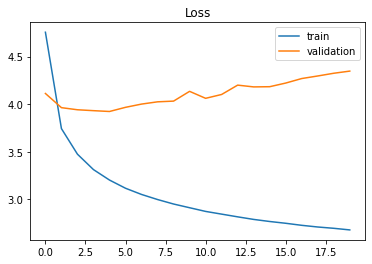

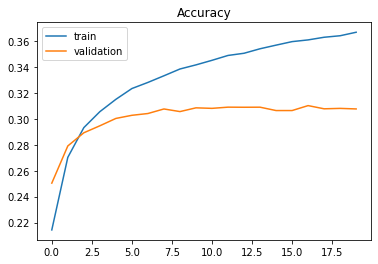

In [126]:
plt.title(f'Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.title(f'Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [118]:
# model=load_model('../../../data/explore/image_caption_generator/output/lstm_image_captioning_model.h5')

In [127]:
model.save('../../../data/explore/image_caption_generator/output/lstm_image_captioning_model.h5')

### Prediction caption on new images downloaded from google

In [128]:
def tokenized_idx_to_word(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==idx:
            return word
    return None

# generate caption for an image
def predict_caption(model, image_feature, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequencems
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = tokenized_idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text
# predict_caption(model, new_image_feature, tokenizer, maxlen)

In [136]:
image_prediction_dir='../../../data/explore/image_caption_generator/prediction'
new_image_feature=image_feature_extraction(image_prediction_dir, resnet50)

In [134]:
Image_caption_prediction=pd.DataFrame({'image':new_image_feature.keys(), 'image_feature':new_image_feature.values()})
Image_caption_prediction['image_feature']=Image_caption_prediction['image_feature'].apply(lambda x: x)
Image_caption_prediction['caption']=Image_caption_prediction['image_feature'].apply(lambda x: predict_caption(model, x, tokenizer, maxlen))
Image_caption_prediction

,image,image_feature,caption
0,dog,"[[0.309161, 1.0375904, 1.2587302, 0.16566096, ...",startseq dog run along beach endseq
1,menInwater,"[[0.6202339, 0.24474798, 0.4481918, 0.04732994...",startseq man in yellow wetsuit be surf on wave...


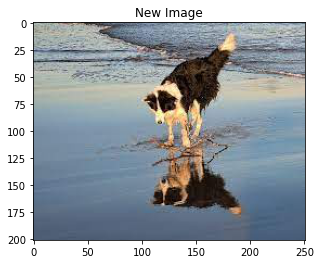

output: dog run along beach


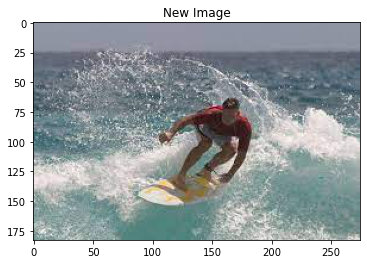

output: man in yellow wetsuit be surf on wave


In [144]:
# image_directory='Image_captioning_Dataset/Flicker8k_Dataset'
for image in list(Image_caption_prediction.image):
    plt.figure()
    im = img.imread(image_prediction_dir + '/'+ image + '.jfif')
    plt.imshow(im) 
    plt.title('New Image')
    plt.show()
    for caption in Image_caption_prediction[Image_caption_prediction['image']==image].caption.values:#.iloc[0]
        print(f"output: {' '.join(caption.split()[1:-1])}")
#     print(image_captions[image_captions['image']==image].caption.iloc[0])
    


### Conclusion

Based on current implementation and given data, model has been trained for 20 epoch and achieved accuracy of 30% for validation data.

From the loss curve, it has been observed that model is overfitting a bit which can be because of less data or model configuration.

We have predicted the caption for two new image & it seems good even with this model.

Model can be further tuned to increase its accuracy by optimizing its hyper parameters but with given resources & time constraint, it is fairly giving correct results.

We can also check bleu score to further validate the model if more data is given.